In [ ]:
# default_exp models.dnn

In [ ]:
# hide
import sys

sys.path.append("..")

# DNN model

> A basic architecture for time series forecasting.


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
class DNN(torch.nn.Module):
    """Implements a simple `DNN` architecture for time series forecasting. Inherits 
    from pytorch `Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`_.
    
    Arguments:
        * input_channels (int): Number of covariates in input time series.
        * output_channels (int): Number of target time series.
        * horizon (int): Number of time steps to forecast.
        * lookback (int): Number of time steps to lookback.
        * hidden_channels (int): Number of channels in convolutional hidden layers.
        * p_dropout (float): Probality of dropout.
    """
    split = -1
    def __init__(self,
                 input_channels,
                 output_channels,
                 horizon,
                 lookback,
                 hidden_channels=64,
                 p_dropout=.2,
                 ks=3,
                ):
        """Inititalize variables."""
        super(DNN, self).__init__()        
        self.output_channels = output_channels
        self.horizon = horizon
        self.hidden_channels = hidden_channels

        # Set up first layer for input
        conv_input = ConvLayer(input_channels, hidden_channels, ks=ks, ndim=1)
#         conv_input = torch.nn.Conv1d(
#             in_channels=input_channels,
#             out_channels=hidden_channels,
#             kernel_size=ks,
#             padding=(ks-1)//2
#         )
        
        # Set up nonlinear output layers
        self.body = nn.Sequential(conv_input,Flatten())          
        self.dnn = LinBnDrop((hidden_channels*lookback),horizon*output_channels)

    def forward(self, inputs):
        """Forward function."""
        hid = self.body(inputs.float())
        out= self.dnn(hid).view(hid.size(0),self.output_channels,-1).float()
        return out
    
    @property
    def n_parameters(self):
        """Returns the number of model parameters."""
        par = list(self.parameters())
        s = sum([np.prod(list(d.size())) for d in par])
        return s


In [ ]:
#export
@delegates(DNN.__init__)
def dnn_learner(dbunch, output_channels=None, metrics=None, **kwargs):
    "Build a dnn style learner"
    output_channels = ifnone(output_channels,dbunch.train[0][0].shape[0])
    
    model = DNN(input_channels=dbunch.train[0][0].shape[0],
        output_channels=output_channels, 
        horizon = dbunch.train_dl.horizon,
        lookback = dbunch.train_dl.lookback, 
        **kwargs
       )
    
    learn = Learner(dbunch, model, loss_func=F.mse_loss, opt_func= Adam, metrics=L(metrics)+L(mae, smape))
    return learn

In [ ]:
from fastseq.all import *
from fastai2.basics import *

path = untar_data(URLs.m4_daily)
data = TSDataBunch.from_folder(path, horizon = 14, lookback = 128, bs = 64, nrows=100)
learn = dnn_learner(data)

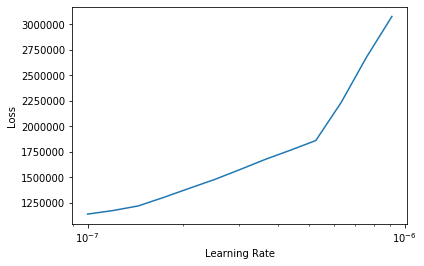

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
learn.fit(2,1e-7)

epoch,train_loss,valid_loss,mae,smape,time
0,17949754.000000,24625564.000000,3965.501953,199.880798,00:16
1,17949742.000000,24622114.000000,3965.427246,199.888702,00:16


In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted 06_models.dnn.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 20_models.cnn.learner.ipynb.
Converted 21_models.cnn.transforms.ipynb.
Converted index.ipynb.
